In [12]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "./cifar-10-100n/")

import os
import torch
from PIL import Image as im
import pandas as pd
import numpy as np
from autogluon.vision import ImagePredictor, ImageDataset
import pickle
import datetime
from pathlib import Path
import cleanlab

from data.datasets import input_dataset
from cross_validation_autogluon import cross_val_predict_autogluon_image_dataset

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [13]:
?cross_val_predict_autogluon_image_dataset

Signature:
cross_val_predict_autogluon_image_dataset(
    dataset: gluoncv.auto.data.dataset.ImageClassificationDataset,
    out_folder: str = './cross_val_predict_run/',
    *,
    n_splits: int = 5,
    model_params: Dict = {'epochs': 1, 'holdout_frac': 0.2},
    ngpus_per_trial: int = 1,
    time_limit: int = 7200,
    random_state: int = 123,
) -> Tuple
Docstring:
Run stratified K-folds cross-validation with AutoGluon image model.

Parameters
----------
dataset : gluoncv.auto.data.dataset.ImageClassificationDataset
  AutoGluon dataset for image classification.

out_folder : str, default="./cross_val_predict_run/"
  Folder to save cross-validation results. Save results after each split (each K in K-fold).

n_splits : int, default=3
  Number of splits for stratified K-folds cross-validation.

model_params : Dict, default={"epochs": 1, "holdout_frac": 0.2}
  Passed into AutoGluon's `ImagePredictor().fit()` method.

ngpus_per_trial : int, default=1
  Passed into AutoGluon's `ImagePredi

## Read data

In [4]:
# get labels
noise_file = torch.load('./cifar-10-100n/data/CIFAR-10_human.pt')
clean_label = noise_file['clean_label']
worst_label = noise_file['worse_label']
aggre_label = noise_file['aggre_label']
random_label1 = noise_file['random_label1']
random_label2 = noise_file['random_label2']
random_label3 = noise_file['random_label3']

In [5]:
# get data
dataset = "cifar10"
noise_type = "worse_label"
noise_path = "./cifar-10-100n/data/CIFAR-10_human.pt"
is_human = True

train_dataset, test_dataset, num_classes,num_training_samples = \
    input_dataset(dataset, noise_type, noise_path, is_human)

Loaded worse_label from ./cifar-10-100n/data/CIFAR-10_human.pt.
The overall noise rate is 0.40208
noisy labels loaded from ./cifar-10-100n/data/CIFAR-10_human.pt
The noisy data ratio in each class is [0.10618 0.12106 0.10684 0.09346 0.0808  0.11336 0.08406 0.10546 0.09258
 0.0962 ]
over all noise rate is  0.40208


Noisy Label: 3
Label: 5


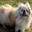

In [7]:
# check out some images
idx = 40
X = train_dataset.train_data[idx]
noisy_label = train_dataset.train_noisy_labels[idx]
label = train_dataset.train_labels[idx]
print(f"Noisy Label: {noisy_label}")
print(f"Label: {label}")
im.fromarray(X)

## Save images to folder

AutoGluon image models require the data to be image files in a folder

We'll save the images as PNG files in a single folder and save their file paths in a list

In [8]:
%%time

# create folder
SAVE_PATH = "./cifar-10n-png/train/"
os.makedirs(SAVE_PATH)

# save images to folder

image_file_paths = [] # list of image file paths

for i, data in enumerate(train_dataset.train_data):
    
    # convert data to image object
    image = im.fromarray(data) 

    # path to image PNG file
    png_file = f"{SAVE_PATH}image_id_{i}.png"
    
    # print the number of images saved
    print(f"Images saved: {i + 1}", end="\r")
    
    # append file to list of file paths
    image_file_paths.append(png_file)
    
    # save image as PNG
    image.save(png_file)

CPU times: user 42.5 s, sys: 8.24 s, total: 50.7 s
Wall time: 1min 7s


## Create DataFrame to use as input for AutoGluon Image predictor

In [41]:
# Note: AutoGluon requires the column names to be "image" and "label"
df_train = pd.DataFrame({
    "image": image_file_paths,
    "label": train_dataset.train_noisy_labels # noisy labels
})

In [42]:
df_train.head()

,image,label
0,./cifar-10n-png/train/image_id_0.png,4
1,./cifar-10n-png/train/image_id_1.png,9
2,./cifar-10n-png/train/image_id_2.png,0
3,./cifar-10n-png/train/image_id_3.png,5
4,./cifar-10n-png/train/image_id_4.png,1


# Optional: copy the images to a faster drive (e.g. M.2 SSD) which will speedup training

In [26]:
# !cp -r ./cifar-10n-png/ /Data/cifar-10n-png/

In [27]:
# !ls /Data/cifar-10n-png

In [43]:
# add prefix to file path if we moved it to another drive
prefix = "/Data/"
df_train["image"] = df_train.image.map(lambda f: str(Path(prefix + f)))
df_train.head()

,image,label
0,/Data/cifar-10n-png/train/image_id_0.png,4
1,/Data/cifar-10n-png/train/image_id_1.png,9
2,/Data/cifar-10n-png/train/image_id_2.png,0
3,/Data/cifar-10n-png/train/image_id_3.png,5
4,/Data/cifar-10n-png/train/image_id_4.png,1


In [45]:
df_train.iloc[0]

image    /Data/cifar-10n-png/train/image_id_0.png
label                                           4
Name: 0, dtype: object

In [52]:
!ls

0bf22b7d			       a3292b9f		       e0705ad5
331ca34a			       a6b2c926		       e5ab5b04
53d0bfc3			       cifar-10-100n	       play.ipynb
961e4305			       cifar-10-100n-main.zip
Prepare_CIFAR-10N_For_Autogluon.ipynb  cifar-10n-png


## Run cross-validation with AutoGluon

In [51]:
%%time

# generate cross-validated predicted probabilities for various models so we can use them for ensemble scoring methods
models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

epochs = 100
holdout_frac = 0.2
n_splits = 5

# run cross-validation for each model
for model in models:
    
    print("----")
    print(f"Running cross-validation for model: {model}")

    MODEL_PARAMS = {
        "model": model,
        "epochs": epochs,
        "holdout_frac": holdout_frac
    }

    # results of cross-validation will be saved to pickle files for each model/fold
    _ = \
        cross_val_predict_autogluon_image_dataset(
            dataset=df_train, # train with NOISY LABELS
            out_folder=f"./cifar-10n-png_noise_type_worst_cv_{model}/", # save results of cross-validation in pickle files for each fold
            n_splits=n_splits,
            model_params=MODEL_PARAMS
        )

----
Running cross-validation for model: resnet18
----
Running Cross-Validation on Split: 0


modified configs(<old> != <new>): {
root.img_cls.model   resnet101 != resnet18
root.train.early_stop_max_value 1.0 != inf
root.train.early_stop_baseline 0.0 != -inf
root.train.early_stop_patience -1 != 10
root.train.batch_size 32 != 16
root.train.epochs    200 != 100
root.misc.seed       42 != 660
root.misc.num_workers 4 != 16
}
Saved config to /dcai/src/experiments/cifar-n/a6b2c926/.trial_0/config.yaml
Model resnet18 created, param count:                                         11181642
AMP not enabled. Training in float32.
Disable EMA as it is not supported for now.
Start training from [Epoch 0]
Epoch[0] Batch [49]	Speed: 232.370721 samples/sec	accuracy=0.126250	lr=0.000100
Epoch[0] Batch [99]	Speed: 515.538348 samples/sec	accuracy=0.125625	lr=0.000100
Epoch[0] Batch [149]	Speed: 531.036058 samples/sec	accuracy=0.137917	lr=0.000100
Epoch[0] Batch [199]	Speed: 512.810578 samples/sec	accuracy=0.145313	lr=0.000100
Epoch[0] Batch [249]	Speed: 493.327027 samples/sec	accuracy=0.154500	lr=0

RuntimeError: Unexpected error happened during fit: { 'args': "{'img_cls': {'model': 'resnet18', 'pretrained': True, "
          "'global_pool_type': None}, 'data': {'img_size': None, 'input_size': "
          "None, 'crop_pct': 0.99, 'mean': None, 'std': None, 'interpolation': "
          "'', 'validation_batch_size_multiplier': 1}, 'optimizer': {'opt': "
          "'sgd', 'opt_eps': None, 'opt_betas': None, 'momentum': 0.9, "
          "'weight_decay': 0.0001, 'clip_grad': None, 'clip_mode': 'norm'}, "
          "'train': {'batch_size': 16, 'sched': 'step', 'lr': 0.01, "
          "'lr_noise': None, 'lr_noise_pct': 0.67, 'lr_noise_std': 1.0, "
          "'lr_cycle_mul': 1.0, 'lr_cycle_limit': 1, 'transfer_lr_mult': 0.01, "
          "'output_lr_mult': 0.1, 'warmup_lr': 0.0001, 'min_lr': 1e-05, "
          "'epochs': 100, 'start_epoch': 0, 'decay_epochs': 30, "
          "'warmup_epochs': 3, 'cooldown_epochs': 10, 'patience_epochs': 10, "
          "'decay_rate': 0.1, 'bn_momentum': None, 'bn_eps': None, 'sync_bn': "
          "False, 'early_stop_patience': 10, 'early_stop_min_delta': 0.001, "
          "'early_stop_baseline': -inf, 'early_stop_max_value': inf}, "
          "'augmentation': {'no_aug': False, 'scale': (0.08, 1.0), 'ratio': "
          "(0.75, 1.3333333333333333), 'hflip': 0.5, 'vflip': 0.0, "
          "'color_jitter': 0.4, 'auto_augment': None, 'mixup': 0.0, 'cutmix': "
          "0.0, 'cutmix_minmax': None, 'mixup_prob': 1.0, 'mixup_switch_prob': "
          "0.5, 'mixup_mode': 'batch', 'mixup_off_epoch': 0, 'smoothing': 0.1, "
          "'train_interpolation': 'random', 'drop': 0.0, 'drop_path': None, "
          "'drop_block': None}, 'model_ema': {'model_ema': True, "
          "'model_ema_force_cpu': False, 'model_ema_decay': 0.9998}, 'misc': "
          "{'seed': 660, 'log_interval': 50, 'num_workers': 16, 'save_images': "
          "False, 'amp': False, 'apex_amp': False, 'native_amp': False, "
          "'pin_mem': False, 'prefetcher': False, 'eval_metric': 'top1', "
          "'tta': 0, 'use_multi_epochs_loader': False, 'torchscript': False}, "
          "'gpus': [0]}",
  'time': 10.478505373001099,
  'traceback': 'Traceback (most recent call last):\n'
               '  File '
               '"/usr/local/lib/python3.8/dist-packages/gluoncv/auto/tasks/image_classification.py", '
               'line 195, in _train_image_classification\n'
               '    result = estimator.fit(train_data=train_data, '
               'val_data=val_data, time_limit=wall_clock_tick-tic)\n'
               '  File '
               '"/usr/local/lib/python3.8/dist-packages/gluoncv/auto/estimators/base_estimator.py", '
               'line 175, in fit\n'
               '    ret = self._fit(train_data, val_data, '
               'time_limit=time_limit) if not resume else \\\n'
               '  File '
               '"/usr/local/lib/python3.8/dist-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", '
               'line 128, in _fit\n'
               '    return self._resume_fit(train_data, val_data, '
               'time_limit=time_limit)\n'
               '  File '
               '"/usr/local/lib/python3.8/dist-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", '
               'line 206, in _resume_fit\n'
               '    return self._train_loop(train_loader, val_loader, '
               'time_limit=time_limit)\n'
               '  File '
               '"/usr/local/lib/python3.8/dist-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", '
               'line 244, in _train_loop\n'
               '    train_metrics = self.train_one_epoch(\n'
               '  File '
               '"/usr/local/lib/python3.8/dist-packages/gluoncv/auto/estimators/torch_image_classification/torch_image_classification.py", '
               'line 367, in train_one_epoch\n'
               '    loss.backward(create_graph=second_order)\n'
               '  File '
               '"/usr/local/lib/python3.8/dist-packages/torch/_tensor.py", '
               'line 307, in backward\n'
               '    torch.autograd.backward(self, gradient, retain_graph, '
               'create_graph, inputs=inputs)\n'
               '  File '
               '"/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py", '
               'line 154, in backward\n'
               '    Variable._execution_engine.run_backward(\n'
               'KeyboardInterrupt\n',
  'train_acc': -1,
  'valid_acc': -1}